<a href="https://colab.research.google.com/github/MeghanaVandana/Advanced_Mathematical_Statistics/blob/main/Project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt

In [3]:

url = "https://raw.githubusercontent.com/MeghanaVandana/Advanced_Mathematical_Statistics/main/Project5/us-violence-brief-1.xls"


try:
    df = pd.read_excel(url)
except:
    # Try forcing "xlrd" engine if available
    try:
        df = pd.read_excel(url, engine="xlrd")
    except:
        # Use openpyxl fallback (GitHub may deliver xlsx even if extension says .xls)
        df = pd.read_excel(url, engine="openpyxl")

print("Columns found:", df.columns.tolist())
print(df.head())

Columns found: ['year', 'month', 'day', 'latitude', 'longitude', 'fatalities']
   year  month  day  latitude  longitude  fatalities
0  2020      1   27   38.8137   -76.9453           1
1  2020      1   28   40.0444  -111.7320           0
2  2020      1   31   30.3674   -89.0928           1
3  2020      2    1   33.9375  -117.2310           1
4  2020      2    4   35.0887   -92.4421           1


In [4]:
def detect_cols(df):
    cols = df.columns
    year = next((c for c in cols if "year" in c.lower()), None)
    month = next((c for c in cols if "month" in c.lower()), None)
    day = next((c for c in cols if "day" in c.lower()), None)
    lat = next((c for c in cols if "lat" in c.lower()), None)
    lon = next((c for c in cols if "lon" in c.lower() or "long" in c.lower()), None)
    fatal = next(
        (c for c in cols if set(df[c].dropna().unique()).issubset({0, 1})),
        None,
    )
    return year, month, day, lat, lon, fatal

year, month, day, lat, lon, target = detect_cols(df)

print("Detected columns:")
print("Year:", year, "Month:", month, "Day:", day)
print("Lat:", lat, "Lon:", lon, "Target:", target)

Detected columns:
Year: year Month: month Day: day
Lat: latitude Lon: longitude Target: fatalities


In [5]:

df["date"] = pd.to_datetime(dict(year=df[year], month=df[month], day=df[day]))
df["days_since_2020"] = (df["date"] - pd.Timestamp("2020-01-01")).dt.days
df["year"] = df["date"].dt.year

df = df.dropna(subset=[lat, lon, target])

In [6]:
# 4. TRAIN / TEST SPLIT (2020–2022 vs 2023)


train = df[df["year"].isin([2020, 2021, 2022])]
test = df[df["year"] == 2023]

X_train = train[["days_since_2020", lat, lon]].values
y_train = train[target].values

X_test = test[["days_since_2020", lat, lon]].values
y_test = test[target].values

# Standardize
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

In [7]:
#TRY ODD K VALUES

k_values = range(1, 26, 2)
results = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_s, y_train)
    preds = knn.predict(X_test_s)

    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average='binary')

    results.append([k, acc, prec, rec, f1])

# Show results
results_df = pd.DataFrame(results, columns=["k", "accuracy", "precision", "recall", "f1"])
print(results_df)


     k  accuracy  precision    recall        f1
0    1  0.834101        0.5  0.055556  0.100000
1    3  0.834101        0.5  0.027778  0.052632
2    5  0.838710        1.0  0.027778  0.054054
3    7  0.834101        0.0  0.000000  0.000000
4    9  0.834101        0.0  0.000000  0.000000
5   11  0.834101        0.0  0.000000  0.000000
6   13  0.834101        0.0  0.000000  0.000000
7   15  0.834101        0.0  0.000000  0.000000
8   17  0.834101        0.0  0.000000  0.000000
9   19  0.834101        0.0  0.000000  0.000000
10  21  0.834101        0.0  0.000000  0.000000
11  23  0.834101        0.0  0.000000  0.000000
12  25  0.834101        0.0  0.000000  0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.p


Best K: 5.0

Confusion Matrix:
[[181   0]
 [ 35   1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       181
           1       1.00      0.03      0.05        36

    accuracy                           0.84       217
   macro avg       0.92      0.51      0.48       217
weighted avg       0.86      0.84      0.77       217



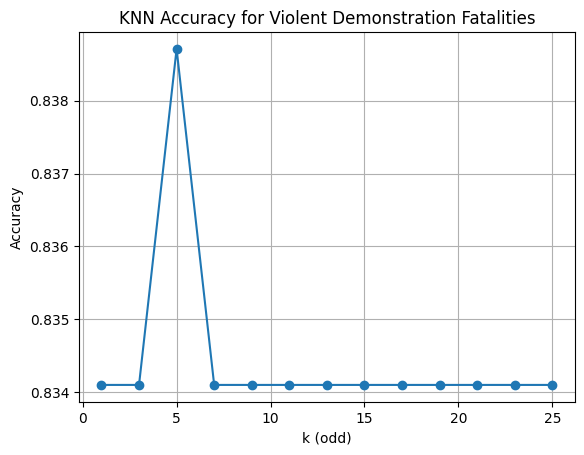

In [8]:
#BEST k


best_k = results_df.sort_values(["accuracy", "f1"], ascending=False).iloc[0]["k"]
print("\nBest K:", best_k)

best_model = KNeighborsClassifier(n_neighbors=int(best_k))
best_model.fit(X_train_s, y_train)
best_preds = best_model.predict(X_test_s)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, best_preds))

print("\nClassification Report:")
print(classification_report(y_test, best_preds))

#PLOT ACCURACY VS k


plt.plot(results_df["k"], results_df["accuracy"], marker="o")
plt.xlabel("k (odd)")
plt.ylabel("Accuracy")
plt.title("KNN Accuracy for Violent Demonstration Fatalities")
plt.grid(True)
plt.show()